# Lake Depth Random Forest model

#### Using:
1. cuDf for data pre-processing
2. cuML for machine learning algorithm implementations
3. Dask for rapids parallelization of GPU code
4. sklearn for metrics

#### Import our model object
Best model is saved

In [2]:
from load_dataset import custom_lakedepth
from models import custom_RF as crf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]
from pprint import pprint

#### Import LakeDepth dataset object
##### Split into training and testing

In [3]:
primary_dataset = custom_lakedepth.LakeDepth(random_state = 42)
covariates_train, covariates_test, labels_train, labels_test = primary_dataset.split(0.20)

 - from DATA: reading csv into GPU memory
 - from DATA: done reading csv into GPU memory
 - from DATA: dropped column: FID
 - from DATA: dropped column: Date


### Random Forest (best model so far) parameters

In [4]:
best_rf_model = crf.load_model('best_test_02.sav')
pprint(best_rf_model.model.get_params())

{'accuracy_metric': 'mean_ae',
 'bootstrap': False,
 'bootstrap_features': False,
 'handle': <cuml.raft.common.handle.Handle object at 0x7fa7257ad470>,
 'max_batch_size': 128,
 'max_depth': 90,
 'max_features': 'sqrt',
 'max_leaves': -1,
 'min_impurity_decrease': 0.0,
 'min_rows_per_node': 2,
 'n_bins': 18,
 'n_estimators': 1715,
 'output_type': 'cudf',
 'quantile_per_tree': False,
 'rows_sample': 1.0,
 'split_algo': 1,
 'split_criterion': 2,
 'use_experimental_backend': False,
 'verbose': 4}


### Training times (w/ Dask Implementation):
#### with max-depth at sub-80
1.        trees < 500  : 01-02 sec training time
2. 500  < trees < 1000 : 03-04 sec training time
3. 100  < trees < 1500 : 04-05 sec training time
5. 1500 < trees < 2000 : 05-12 sec training time

#### with max-depth at 80+
1.        trees < 500  : 03-04 sec training time
2. 500  < trees < 1000 : 04-09 sec training time
3. 100  < trees < 1500 : 09-15 sec training time
5. 1500 < trees < 2000 : 15-25 sec training time

## Metrics
#### measure the models abilities through
1. Mean Absolute Error
2. r2_score
3. Mean Square Error

In [5]:
predictions, mae, r2, mse = best_rf_model.get_metrics(covariates_test, labels_test)

Scores ------
 MAE:  0.17171578
  r2:  0.9232614030700259
 MSE:  0.25320458


-- Still not great on MAE considering the limited range of depths we're working for

## Results Visualization

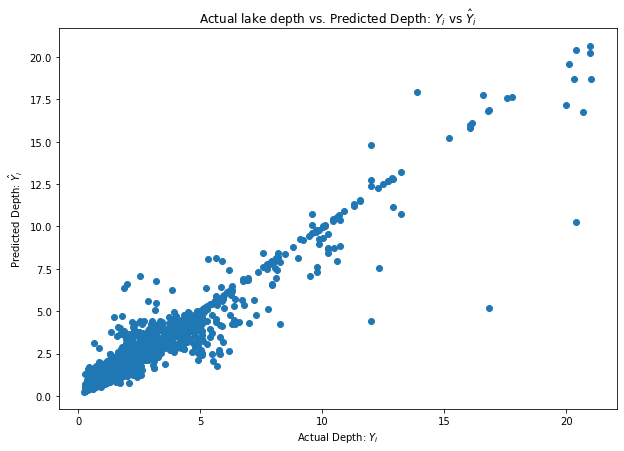

In [6]:
plt.scatter(labels_test.to_array(), predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Depth: $\hat{Y}_i$")
plt.title("Actual lake depth vs. Predicted Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Random sampling of actual vs predicted data

In [7]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
import random
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {:20}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               predictions.to_array()[random_data_point]))

Data-point:  1533 Actual:   1.3824399709701538 Predicted:   1.9674100875854492
Data-point:  2838 Actual:   1.3484300374984741 Predicted:    1.360365629196167
Data-point:  3070 Actual:    5.712699890136719 Predicted:   5.6087799072265625
Data-point:  3892 Actual:   1.8312699794769287 Predicted:   1.8072260618209839
Data-point:  2911 Actual:   1.3176499605178833 Predicted:   1.3776131868362427
Data-point:  3030 Actual:   1.8472000360488892 Predicted:   1.8346235752105713
Data-point:  1824 Actual:    1.128999948501587 Predicted:   1.1646407842636108
Data-point:  2604 Actual:   0.6299999952316284 Predicted:   0.7716125845909119
Data-point:  1218 Actual:    2.695499897003174 Predicted:    2.730579137802124
Data-point:   225 Actual:   2.1983299255371094 Predicted:   2.1990458965301514
Data-point:  1897 Actual:  0.44999998807907104 Predicted:    0.450412780046463
Data-point:  3706 Actual:   1.8705300092697144 Predicted:   1.8414651155471802
Data-point:    21 Actual:   1.9743800163269043 Predi

## Feature Importance

Using sklearn's permutation importance


Variables: b35_LC8_07           Importance: -0.07565
Variables: b27_LC8_07           Importance: -0.07609
Variables: b15_LC8_07           Importance: -0.07717
Variables: b28_LC8_07           Importance: -0.07832
Variables: b31_LC8_07           Importance: -0.07849
Variables: b16_LC8_07           Importance: -0.08179
Variables: b32_LC8_07           Importance: -0.08718
Variables: b9_LC8_075           Importance: -0.09359
Variables: b22_LC8_07           Importance: -0.09563
Variables: b14_LC8_07           Importance: -0.09585
Variables: b33_LC8_07           Importance: -0.09611
Variables: b6_LC8_075           Importance: -0.09988
Variables: b4_LC8_075           Importance: -0.10109
Variables: b10_LC8_07           Importance: -0.10326
Variables: b11_LC8_07           Importance: -0.10628
Variables: b5_LC8_075           Importance: -0.10841
Variables: b34_LC8_07           Importance: -0.11652
Variables: b30_LC8_07           Importance: -0.11926
Variables: b21_LC8_07           Importance: -0

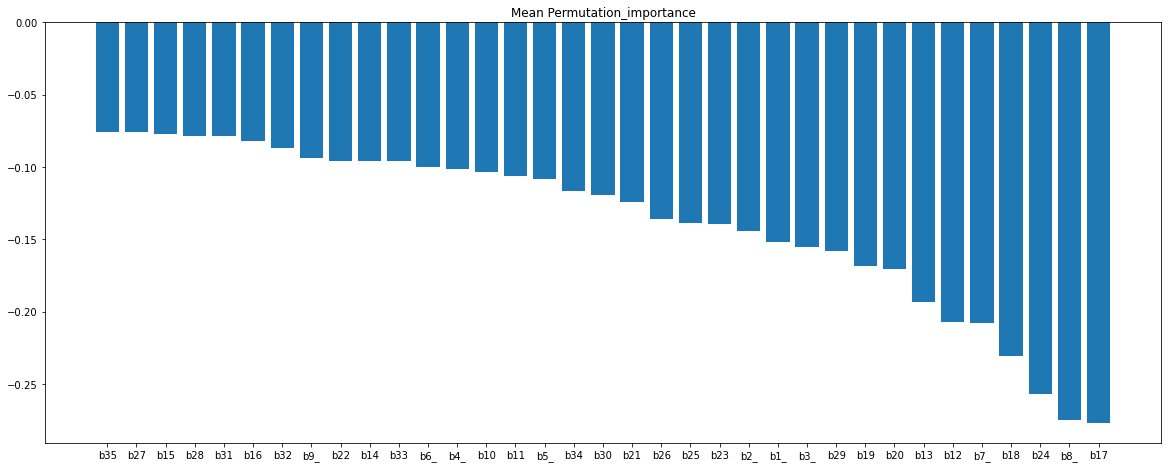

In [8]:
best_rf_model.feature_importances(covariates_train, labels_train, show = True)

## Final Points

* Dask combined with cuDF/cuML is still experimental
* We see significant speedups during training time